# Домашнее задание от Сани
Для справки мне больше нравится Американский папаша, а не Симпсоны. Рик и Морти конечно гораздо круче, но что поделаешь, новый сезон разрабатывают за 1-1,5 года. 
Я помню, что должен еще 2 ПЗ, на этой неделе сделаю.
У меня были важные дела(нет) из-за этого все время откладывал


In [1]:
!pip install torch
!pip install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()
#провекра на чем проходит обучение CPU or GPU, прикольно
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [6]:
#Модуль pickle реализует бинарные протоколы для сериализации и десериализации структуры объекта
''' 

- Сериализация имеющихся объектов – это процесс сохранения состояния объекта в последовательность байт. Механизм, который позволят «записывать» полученный прогресс для будущей выгрузки.

- Десериализация – восстановление объектов из байт, сохранение которых было произведено ранее. Процедура выгрузки «зафиксированной» информации пользователем. 

'''
import pickle
#все понятно
import numpy as np
#scikit-image — это пакет Python для обработки изображений, который работает с массивами numpy
from skimage import io
#Декоратор прогрессбара IPython/Jupyter Notebook для итераторов. Включает rangeитератор по умолчанию, печатающий в stderr.
from tqdm import tqdm, tqdm_notebook
#Модуль Imageпредоставляет класс с тем же именем, который используется для представления изображения PIL. Модуль также предоставляет ряд заводских функций, в том числе функции загрузки изображений из файлов и создания новых изображений.
from PIL import Image
#Pathlib предоставляет удобный для чтения и простой способ создания путей, представляя пути файловой системы в виде надлежащих объектов. Модуль позволяет создавать код, который можно переносить между платформами.
from pathlib import Path
#Эта библиотека поддерживает множество операций по увеличению изображения.
from torchvision import transforms
#multiprocessing это пакет, который поддерживает процессы порождения с использованием API, аналогичного модулю threading. 
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
#служат для упрощения и ускорения загрузки данных и экономии памяти.
from torch.utils.data import Dataset, DataLoader
#возможность выбрать типы слоев нейронных сетей
import torch.nn as nn
# заставляют matplotlib работать как MATLAB
from matplotlib import colors, pyplot as plt

%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings(эта библа игнорирует предупреждения, только что узнал довольно интересная штука)
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [7]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [8]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [9]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [11]:
TRAIN_DIR = Path('/content/drive/MyDrive/kaggle/input/train/simpsons_dataset')
TEST_DIR = Path('/content/drive/MyDrive/kaggle/input/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [12]:
# модуль train_test_split библиотеки Scikit-learn, который очень полезен для разделения датасетов
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [4]:
#диск
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
val_dataset = SimpsonsDataset(val_files, mode='val')

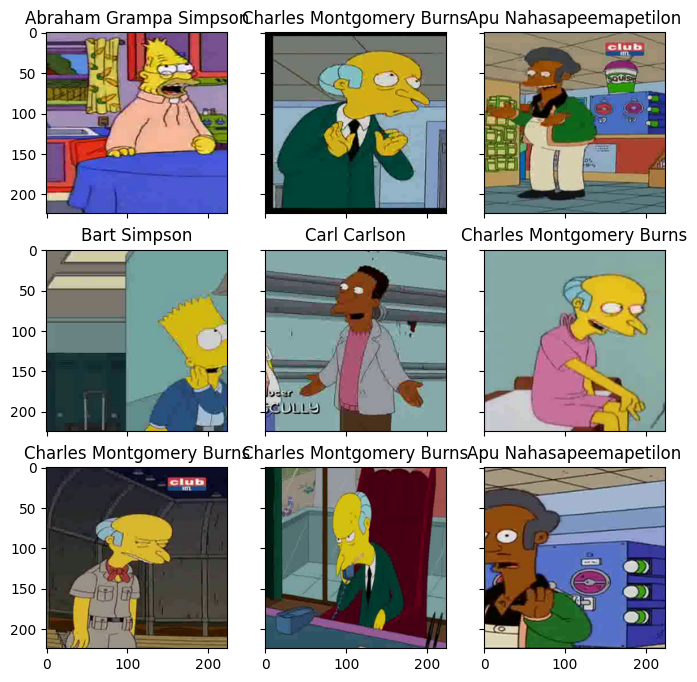

In [14]:
#Отображение датасета 
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Слои:
1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [15]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [16]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [17]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [18]:
import torch.optim as optim
from torch.optim import lr_scheduler

In [19]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_files, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_files, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=4, gamma=0.1)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            model.train()
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            scheduler.step()
            
            model.eval()
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history


In [21]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [22]:
total_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(total_classes).to(DEVICE)
print("we will classify :{}".format(total_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

In [23]:
from torchvision import models

In [24]:
model_extractor = models.googlenet(weights='IMAGENET1K_V1').to(DEVICE)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 94.3MB/s]


In [25]:
model_extractor = models.resnet50(weights='IMAGENET1K_V2').to(DEVICE)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 197MB/s]


In [26]:
model_extractor.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [27]:
#сколько признаков поступает на FC-слой
num_feateres = model_extractor.fc.in_features
num_feateres

2048

In [28]:
#сколько у нас возможных классов
total_classes

42

In [29]:
#замена FC-слоя на подходящий для нашей задачи
model_extractor.fc = nn.Linear(num_feateres, total_classes)

In [30]:
# Обучать модель будем на CUDA
model_extractor = model_extractor.cuda()

In [31]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [33]:
history = train(train_dataset, val_dataset, model=model_extractor, epochs=10, batch_size=128)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.37985020182365686


epoch:  10%|█         | 1/10 [1:00:53<9:08:04, 3653.83s/it]


Epoch 001 train_loss: 0.3799     val_loss 0.5447 train_acc 0.9085 val_acc 0.8592
loss 0.13811335742190747


epoch:  20%|██        | 2/10 [1:07:03<3:49:37, 1722.23s/it]


Epoch 002 train_loss: 0.1381     val_loss 0.5317 train_acc 0.9648 val_acc 0.8745
loss 0.10471166723666278


epoch:  30%|███       | 3/10 [1:13:23<2:09:24, 1109.22s/it]


Epoch 003 train_loss: 0.1047     val_loss 0.2780 train_acc 0.9731 val_acc 0.9301
loss 0.05804775428605676


epoch:  40%|████      | 4/10 [1:19:37<1:21:54, 819.07s/it]


Epoch 004 train_loss: 0.0580     val_loss 0.3837 train_acc 0.9841 val_acc 0.9180
loss 0.021795872752416193


epoch:  50%|█████     | 5/10 [1:25:52<54:53, 658.75s/it]


Epoch 005 train_loss: 0.0218     val_loss 0.1259 train_acc 0.9947 val_acc 0.9740
loss 0.004585164440518738


epoch:  60%|██████    | 6/10 [1:32:04<37:25, 561.30s/it]


Epoch 006 train_loss: 0.0046     val_loss 0.1210 train_acc 0.9994 val_acc 0.9744
loss 0.0027036413131210544


epoch:  70%|███████   | 7/10 [1:38:15<24:57, 499.22s/it]


Epoch 007 train_loss: 0.0027     val_loss 0.1210 train_acc 0.9996 val_acc 0.9748
loss 0.0017014431683934528


epoch:  80%|████████  | 8/10 [1:44:31<15:19, 459.75s/it]


Epoch 008 train_loss: 0.0017     val_loss 0.1224 train_acc 0.9999 val_acc 0.9746
loss 0.0012491158261886638


epoch:  90%|█████████ | 9/10 [1:50:42<07:12, 432.08s/it]


Epoch 009 train_loss: 0.0012     val_loss 0.1239 train_acc 0.9999 val_acc 0.9746
loss 0.0012503583564802577


epoch: 100%|██████████| 10/10 [1:56:52<00:00, 701.25s/it]


Epoch 010 train_loss: 0.0013     val_loss 0.1238 train_acc 0.9999 val_acc 0.9742
